## Using a GAT neural surrogate of potency

Instantiate model structure.

In [27]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import dgym as dg
from dgym.envs import oracle

config = {
    "dropout": 0.05,
    "gnn_hidden_feats": 64,
    "num_heads": 8,
    "alpha": 0.06,
    "predictor_hidden_feats": 128,
    "num_gnn_layers": 5,
    "residual": True
}

model = oracle.build_model_2d(config=config)

Load state dict from disk.

In [104]:
root_dir = '../../dgym-data'
file_name = 'asapdiscovery-SARS-CoV-2-Mpro-GAT-2023.08.25.th'
path = f'{root_dir}/{file_name}'

preloaded_state_dict = torch.load(path)
state_dict = dict(zip(
    model.state_dict().keys(),
    preloaded_state_dict.values()
))

model.load_state_dict(state_dict)
model = model.to(device)

Import data.

In [75]:
import dgym as dg

deck = dg.MoleculeCollection.from_sdf(
    # f'{root_dir}/DSi-Poised_Library_annotated.sdf',
    f'{root_dir}/Mpro_combined_aminopyridine.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

Try predicting.

In [119]:
import dgl
import dgllife

molecules = deck[:]

mol_to_graph = dgllife.utils.MolToBigraph(
    add_self_loop=True,
    node_featurizer=dgllife.utils.CanonicalAtomFeaturizer()
)

# featurize
graphs = [
    mol_to_graph(m.update_cache().mol)
    for m in molecules
]

# batch
graph_batch = dgl.batch(graphs).to(device)

# perform inference
with torch.no_grad():
    preds = model({'g': graph_batch})
    
# convert to dataframe
aff_pred = pd.DataFrame.from_dict({'smiles': deck.smiles, 'pIC50_pred': preds.ravel().tolist()})

Comparing to actuals.

In [128]:
import pandas as pd

# import data
aff_actual = pd.read_csv(f'{root_dir}/CDD CSV Export - 2023-09-11 11h31m13s.csv')
aff_actual = aff_actual[[
    'suspected_SMILES',
    'Canonical PostEra ID',
    'ProteaseAssay_Fluorescence_Dose-Response_Weizmann: IC50 (µM)'
]].copy()
aff_actual.columns = ['smiles', 'postera_id', 'IC50']

# find correspondence
aff_actual = aff_actual[
    aff_actual['postera_id']
    .isin([m.mol.GetProp('_Name') for m in deck])
].copy()

# convert affinity to numeric
aff_actual['IC50'] = pd.to_numeric(aff_actual['IC50'], errors='coerce')

# transform to pIC50
import numpy as np
aff_actual['pIC50'] = -np.log(aff_actual['IC50'] * 1e-3)

# merge
affs = aff_actual.merge(aff_pred, on='smiles')
affs = affs.dropna()

Quantitative metrics.

In [155]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

print('Pearson r:\t', pearsonr(affs['pIC50'], affs['pIC50_pred']).statistic)
print('RMSE:\t\t', mean_squared_error(affs['pIC50'], affs['pIC50_pred'], squared=False))

Pearson r:	 0.6758273713808937
RMSE:		 1.3038944858064483


(2.0, 7.0)

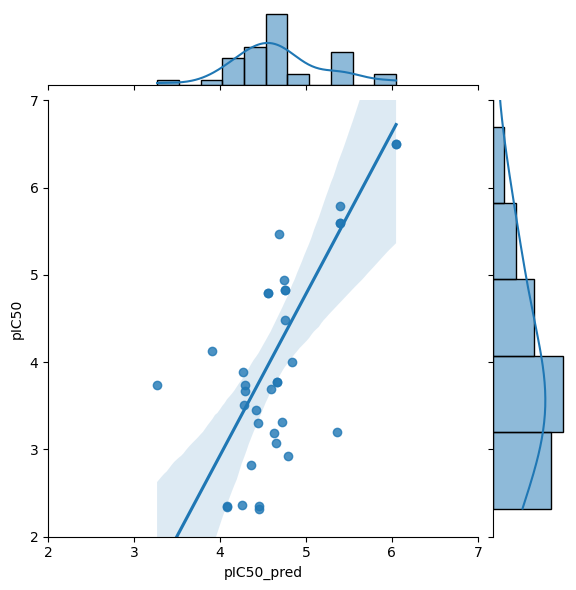

In [156]:
import seaborn as sns

sns.jointplot(
    data=affs,
    x='pIC50_pred',
    y='pIC50',
    kind="reg"
)

import matplotlib.pyplot as plt

plt.xlim([2., 7.])
plt.ylim([2., 7.])